# Hamiltonian simulation - QASM w/tomography (Gray code only)

In [1]:
import warnings
warnings.filterwarnings(action='once')

import numpy as np
np.warnings.filterwarnings('ignore')

import pickle

from scipy.linalg import expm

from pprint import pprint
from tqdm import tqdm

# Everything we need from Qiskit
from qiskit import ClassicalRegister, QuantumRegister, QuantumCircuit
from qiskit import execute, Aer
from qiskit.quantum_info import Pauli

from qiskit.compiler import transpile

from qiskit.ignis.verification import tomography

from qiskit.aqua.operators import WeightedPauliOperator
from qiskit.aqua.components.initial_states import Custom

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
sns.set(rc={'figure.figsize':(16,8)})

import qutip as qt

import sys
sys.path.append("../src/")
from hamiltonian import *
from utils import *
from qiskit_circuits import *
from device import Device

In [2]:
# Perform unitary evolution 
def unitary_evolution(ham, t):
    return expm(-1j * ham * t)

states_gc = ['00', '10', '11', '01']
states_oh = ['1000', '0100', '0010', '0001']

colours = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']

backend = Aer.get_backend('qasm_simulator')

device = Device('ibmq_vigo', mitigate_meas_error=False, N_qubits=5)

## QASM Simulation with quantum state tomography

In [3]:
# Arbitrary simulation time
T = 1

# Range of Trotter steps to use
min_trotter_steps = 1
max_trotter_steps = 100

In [4]:
H_gc = DenseEncodingHamiltonian(N_states=4)

# Get the matrix in "qiskit order"
gc_ham_rep = reduce(lambda x, y: x + y, [p[1] * get_pauli_matrix(p[0]) for p in H_gc.pauli_coeffs.items()])
uniform_superposition_gc = 0.5 * np.array([[1], [1], [1], [1]])

exact_wavefunction_gc = unitary_evolution(gc_ham_rep, t=T) @ uniform_superposition_gc

This code loops over the different numbers of Trotter steps and performs the evolution by running the circuit using the statevector simulator.

In [ ]:
# NOTE: output of this cell has been cleared for readability, due to cvxpy warnings produced in every step

weighted_paulis = [(v, Pauli.from_label(k)) for (k, v) in list(H_gc.pauli_coeffs.items())]
my_pauli = WeightedPauliOperator(weighted_paulis)

trace_dists_gc = np.zeros((4, max_trotter_steps))

for opt_level in range(4):
    for n_trotter_steps in tqdm(range(min_trotter_steps, max_trotter_steps+1)):
        q = QuantumRegister(H_gc.N_qubits)

        circuit = QuantumCircuit(q)

        circuit.h(q)

        circuit += my_pauli.evolve(
            None, evo_time=T, num_time_slices=n_trotter_steps,
            quantum_registers=q,
            expansion_mode='trotter'
        )

        # Gate counts for optimized circuit
        optimized_circuit = transpile(circuit, 
                                      backend=backend,
                                      basis_gates=device.noise_model.basis_gates,
                                      coupling_map=device.coupling_map,
                                      initial_layout=[2, 1],
                                      optimization_level=opt_level)

        ######################
        #     Tomography     #
        ######################
        # Measure only the qubits the circuit is acting on
        tomography_circuits = tomography.state_tomography_circuits(optimized_circuit, [2, 1])
        
        tomo_job = execute(tomography_circuits, backend=backend, shots=10000)
        tomo_results = tomo_job.result()

        fitter = tomography.StateTomographyFitter(tomo_results, tomography_circuits)
        density_mat = fitter.fit()

        trace_dists_gc[opt_level, n_trotter_steps-1] = qt.tracedist(qt.Qobj(exact_wavefunction_gc), qt.Qobj(density_mat))  

Text(0.5, 1.0, 'Gray code, N=4, Hamiltonian evolution time t = 1')

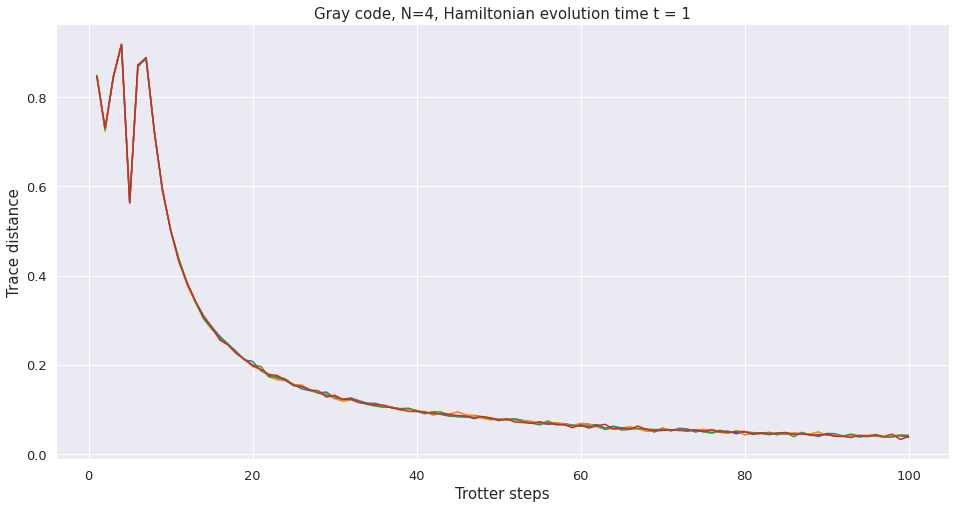

In [9]:
for opt_level in range(4):
    plt.plot(range(min_trotter_steps, max_trotter_steps+1), 
             trace_dists_gc[opt_level,:],
             color=colours[opt_level], label=f"Opt level {opt_level}")
plt.xlabel("Trotter steps", fontsize=15)
plt.ylabel("Trace distance", fontsize=15)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.title(f"Gray code, N=4, Hamiltonian evolution time t = {T}", fontsize=15)
#plt.savefig("gc-trotter-probs.pdf")

Now we'll do the same thing for one-hot. We'll prepare the uniform superposition here by running the variational ansatz with the set of parameters that will produce it.

In [11]:
np.save('gray-code-tomo-nonoise-alloptlevels.npy', trace_dists_gc)

## Generate figure 10

Plot the trace distance of the tomographically reconstructed state obtained using QASM simulations with no additional hardware noise.

In [12]:
trace_dists_oh = np.load('one-hot-tomo-nonoise-alloptlevels.npy')

/home/olivia/Software/anaconda3/envs/deuteron-2/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


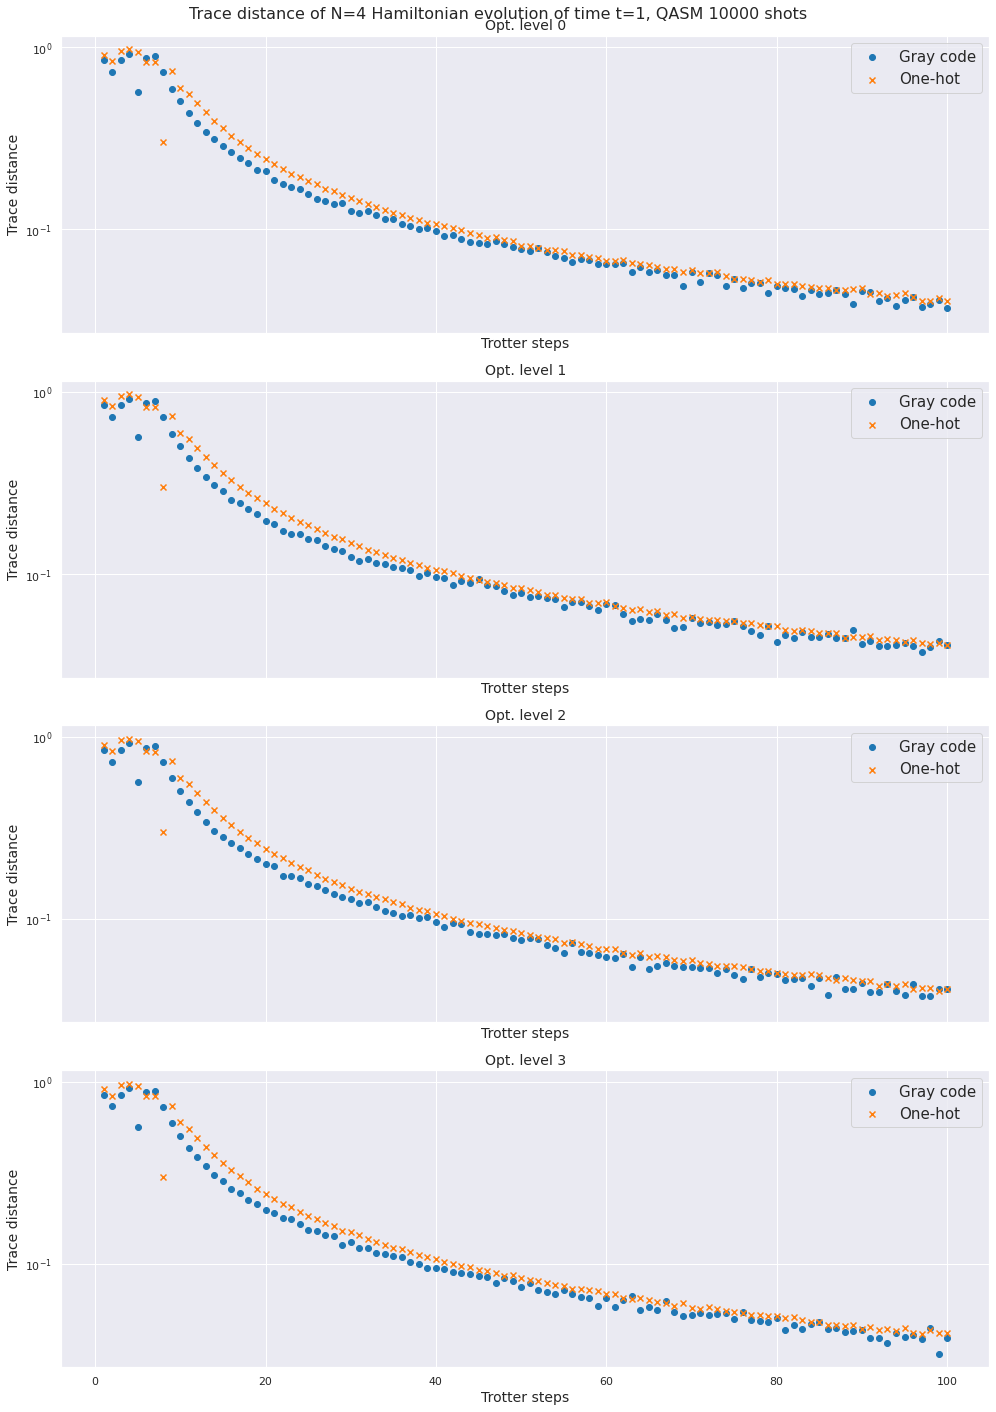

In [14]:
fig, ax = plt.subplots(4, 1, sharex=True, sharey=True, figsize=(14, 20))

for opt_level in range(4):    
    ax[opt_level].scatter(range(min_trotter_steps, max_trotter_steps+1), 
             trace_dists_gc[opt_level,:],
             color=colours[0], marker='o', label=f"Gray code")
    ax[opt_level].scatter(range(min_trotter_steps, max_trotter_steps+1), 
             trace_dists_oh[opt_level,:],
             color=colours[1], marker='x', label=f"One-hot")
    
    ax[opt_level].set_xlabel("Trotter steps", fontsize=14)
    ax[opt_level].set_ylabel("Trace distance", fontsize=14)
    ax[opt_level].set_title(f"Opt. level {opt_level}", fontsize=14)
    ax[opt_level].set_yscale('log')
    ax[opt_level].legend(fontsize=15)   
    
plt.suptitle("Trace distance of N=4 Hamiltonian evolution of time t=1, QASM 10000 shots", fontsize=16)
plt.tight_layout()

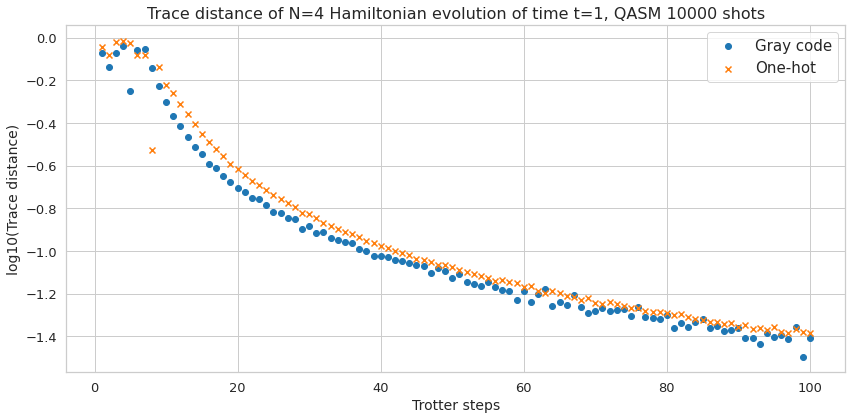

In [23]:
sns.set(rc={'figure.figsize':(12,6)})
plt.rcParams['axes.facecolor'] = 'white'
sns.set_style('whitegrid')

plt.scatter(range(min_trotter_steps, max_trotter_steps+1), 
            np.log10(trace_dists_gc[3,:]), color=colours[0], marker='o', label=f"Gray code")
plt.scatter(range(min_trotter_steps, max_trotter_steps+1), 
            np.log10(trace_dists_oh[3,:]), color=colours[1], marker='x', label=f"One-hot")

plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.xlabel("Trotter steps", fontsize=14)
plt.ylabel("log10(Trace distance)", fontsize=14)
plt.legend(fontsize=15)   
    
plt.title("Trace distance of N=4 Hamiltonian evolution of time t=1, QASM 10000 shots", fontsize=16)
plt.tight_layout()
plt.savefig("fig10.pdf")